In [3]:
from visualization import save_stpts, save_imcs, display_imgs, display_img

## STPT

In [4]:
phys_secs = ['{:03d}'.format(sec) for sec in list(range(1, 5))]  # construct list of physical sections

save_stpts()
# save_stpts(ress=['1'],
#            phys_secs=phys_secs,
#            opt_secs=['00', '01'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

In [26]:
import os
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
img = io.imread('PROCESSED_IMC_DATA/SECTION_01_MATCH_STPT_20Z00/TIF/191Ir_DNA.tif')
plt.imshow(img, cmap='gray')

## IMC

In [2]:
phys_secs = ['{:02d}'.format(sec) for sec in list(range(1, 5))]  # construct list of physical sections

save_imcs(secs=phys_secs,
          img_types=['TIF'],
          data_files=['193Ir_DNA.tif', '191Ir_DNA.tif', 'roi_map.tif', '143Nd_Vimentin.tif'])

<Figure size 432x288 with 0 Axes>

## Display Images

In [10]:
import torch
import matplotlib.pyplot as plt
img = torch.load('processed_data/STPT/08/50_40.pt')
img = img.permute((1, 2, 0))
img.shape

torch.Size([256, 256, 8])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


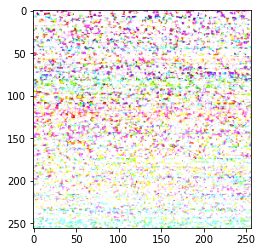

In [11]:
plt.imshow(img[:, :, :4], cmap='gray')

In [22]:
# normalize image (8 bits)
norm_img = img.copy()
cv.normalize(img, norm_img, alpha=0, beta=2**8 - 1, norm_type=cv.NORM_MINMAX)

# Apply log transformation method
c = (2**8 - 1) / np.log(1 + np.max(norm_img))

log_image = c * (np.log(norm_img + 1))
np.max(log_image)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


nan

In [3]:
## STPT
display_imgs("/home/jimaxt/Shared/Notebooks/Kevin/stpt_2_imc/data/STPT/1")

GridBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xb0\x00\x00\x01 \x08\x06\x00\x…

In [ ]:
## IMC
for i in range(1, 18):
    # folder for sec 16 is empty, skip over
    if i == 16:
        continue
    display_imgs("/home/jimaxt/Shared/Notebooks/Kevin/stpt_2_imc/data/IMC/{:02d}".format(i))

## Sandbox

In [2]:
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import re, seaborn as sns

In [57]:
def view(file, dim=2):
    fig = plt.figure(figsize=(10,10))
    img = io.imread(file)
    if dim==2:
        plt.imshow(img)
    else:
        ax = Axes3D(fig)
        fig.add_axes(ax)
        cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
        sc = ax.scatter(img[:, 0], img[:, 1], img[:, 2], s=40, c=img[:, 0], marker='o', cmap=cmap, alpha=1)
    # plt.savefig('/home/jimaxt/Shared/Notebooks/Kevin/visualization/3d_plot')

In [ ]:
view(file='143Nd_Vimentin.tif', dim=2)

In [ ]:
import numpy as np
import torch
x = np.random.rand(256,256).astype('float16')
x = torch.from_numpy(x)

## Visualization

In [ ]:
from visualization import process_stpt_image, process_imc_image

import matplotlib.pyplot as plt
from torchvision import transforms
import torch

### Plot a sample of STPT and IMC image

In [8]:
stpt = process_stpt_image('../data/STPT/S001_Z00.tif').permute(2,0,1)

imc = process_imc_image('../data/IMC/SECTION_01/143Nd_Vimentin.tif')
stpt = transforms.Resize(imc.shape[0])(stpt).permute(1,2,0)

In [9]:
imc = imc[16:18704, 16:18704]
print(stpt.shape)
print(imc.shape)

torch.Size([18720, 18720, 4])
torch.Size([18688, 18688])


In [ ]:
f, (axarr1, axarr2) = plt.subplots(1,2, figsize=(14,6))
axarr1.axis("off")
axarr2.axis("off")
axarr1.set_title('STPT', pad=20)
axarr2.set_title('IMC', pad=20)
axarr1.imshow(stpt.numpy(), cmap='gray')
axarr2.imshow(imc.numpy(), cmap='gray')

f.savefig('../figures/sample_imc_stpt.png')

### Plot chunk

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


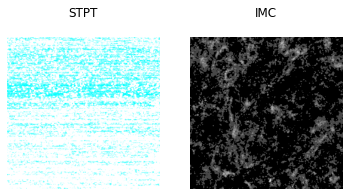

In [10]:
phys_sec = '10'   # choose which physical section to reconstruct
chunk = '40_22'  # choose which chunk to extract

# load images
stpt_piece = torch.load('processed_data/STPT/{0}/{1}.pt'.format(phys_sec.zfill(2), chunk))

imc_piece = torch.load('processed_data/IMC/{0}/{1}.pt'.format(phys_sec.zfill(2), chunk))

f, (axarr1, axarr2) = plt.subplots(1,2)
axarr1.axis("off")
axarr2.axis("off")
axarr1.set_title('STPT', pad=20)
axarr2.set_title('IMC', pad=20)
axarr1.imshow(stpt_piece[:4].permute(1,2,0).numpy(), cmap='gray')
axarr2.imshow(imc_piece.permute(1,2,0)[:,:,5].numpy(), cmap='gray')

# f.savefig('../figures/sample_imc_stpt_crop.png')

### Plot loss curve

In [2]:
from visualization import display_img
from skimage import io, exposure
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time
import torch

In [6]:
unet_output = open('../checkpoints/unet_output.txt')
contents = unet_output.read()
lines = contents.splitlines()

In [7]:
import re

losses = []
for line in lines[1:]:
    try:
        found = re.search('\tLoss (.+?) ', line).group(1)
        losses.append(float(found))
    except AttributeError:
        pass

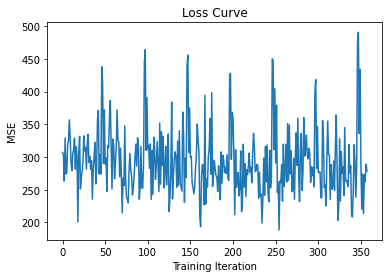

In [10]:
plt.plot(losses)
plt.locator_params(axis='y', nbins=10)
plt.title('Loss Curve')
plt.xlabel('Training Iteration')
plt.ylabel('MSE')
plt.savefig('../figures/unet_loss_curve.png')